In [40]:
# user defined functions

import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
from scipy import stats
from scipy.signal import butter, filtfilt
from pykalman import KalmanFilter
import pingouin as pg
from scipy import fft

import multiprocessing as mp


#plots
import string
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None

In [6]:
dir = '~/DataAnalysis/data/Sprints/HighRes/'

In [7]:
df1 = pd.read_hdf(dir+'Windy/WindyMASigned.h5')
df2 = pd.read_hdf(dir+'NotWindy/NotWindyMASigned.h5')
df3 = pd.read_hdf(dir+'Forest/ForestMASigned.h5')

In [8]:
df=pd.concat([df1,df2,df3])
df.reset_index(inplace=True, drop=True)

In [38]:
def wrapped_angular_diff(a, b):
    return np.arctan2(np.sin(a-b), np.cos(a-b))


def cartesian_to_polar(x, y):
    r = math.sqrt(x**2 + y**2)
    theta = wrapped_angular_diff(y, x)
    return r, theta

def compute_r_dot_theta_dot(x, y, x_dot, y_dot):
    r, theta = cartesian_to_polar(x, y)
    
    r_dot = x_dot * math.cos(theta) + y_dot * math.sin(theta)
    theta_dot = (y_dot * math.cos(theta) - x_dot * math.sin(theta)) / r
    
    return r, theta, r_dot, theta_dot

In [62]:
def wrapped_angular_diff(a, b):
    return np.arctan2(np.sin(a-b), np.cos(a-b))

def compute_r_dot_theta_dot(args):
    xsrc, ysrc, gps_linear_x, gps_linear_y = args
    # Convert from Cartesian to Polar
    r = math.sqrt(xsrc**2 + ysrc**2)
    theta = wrapped_angular_diff(ysrc, xsrc)
    
    # Calculate r_dot and theta_dot
    r_dot = gps_linear_x * math.cos(theta) + gps_linear_y * math.sin(theta)
    theta_dot = (gps_linear_y * math.cos(theta) - gps_linear_x * math.sin(theta)) / r

    return r, theta, r_dot, theta_dot

# Prepare the data for the compute_r_dot_theta_dot function
data = list(zip(df1['xsrc'], df1['ysrc'], df1['gps_linear_x'], df1['gps_linear_y']))

# Create a multiprocessing Pool and map the function to the data
with mp.Pool(mp.cpu_count()) as pool:
    results = pool.map(compute_r_dot_theta_dot, data)

# Convert the results to a DataFrame
result = pd.DataFrame(results, columns=['r', 'theta', 'r_dot', 'theta_dot'])

result['time'] = df1.time


In [63]:
# # Initialize two empty lists for r_dot and theta_dot
# r_list = []
# theta_list = []
# r_dot_list = []
# theta_dot_list = []

# # Loop over each row in the DataFrame
# for i in range(len(df1)):
#     # Call the function and store the results
#     r, theta, r_dot, theta_dot = compute_r_dot_theta_dot(df1.iloc[i]['xsrc'], 
#                                                          df1.iloc[i]['ysrc'], df1.iloc[i]['gps_linear_x'], 
#                                                          df1.iloc[i]['gps_linear_y'])

#     # Append the results to the lists
#     r_list.append(r)
#     theta_list.append(theta)
#     r_dot_list.append(r_dot)
#     theta_dot_list.append(theta_dot)

# # Create a new DataFrame with the results
# result = pd.DataFrame({
#     'r' : r_list,
#     'theta' : theta_list,
#     'r_dot': r_dot_list,
#     'theta_dot': theta_dot_list,
# })

# result['time']=df1.time

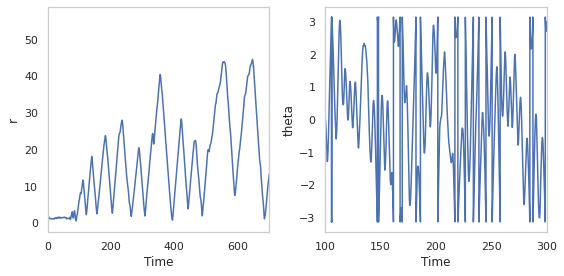

In [67]:
# Assuming 'time' column in df1 DataFrame
f, ax = plt.subplots(1, 2, figsize=(8, 4))  # change to a 1x2 subplot grid

# r_dot vs time
ax[0].plot(result['time'], result['r'])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('r')
ax[0].grid(False)
ax[0].set_xlim(0,700)

# theta_dot vs time
ax[1].plot(result['time'], result['theta'])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('theta')
ax[1].set_xlim(100,300)
ax[1].grid(False)

f.tight_layout()
# f.savefig('../../Figure/r_theta.jpeg', dpi=300, bbox_inches = "tight")

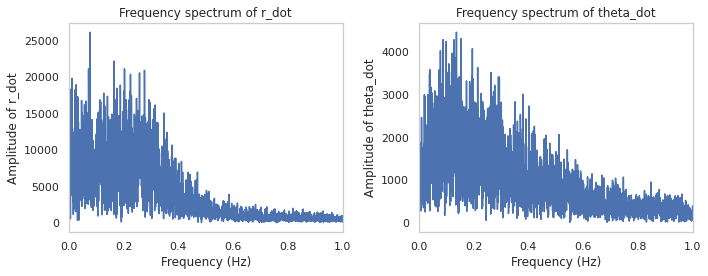

In [70]:
r_dot_fft = np.fft.fft(result['r_dot'])
theta_dot_fft = np.fft.fft(result['theta_dot'])
dt=result.time[1]-result.time[0]
frequencies = np.fft.fftfreq(len(result['r_dot']), d=dt)[:len(result['r_dot'])//2]
r_dot_fft = r_dot_fft[:len(result['r_dot'])//2]
theta_dot_fft = theta_dot_fft[:len(result['theta_dot'])//2]

f, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].grid(False)
ax[0].plot(frequencies, np.abs(r_dot_fft))
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Amplitude of r_dot')
ax[0].set_title('Frequency spectrum of r_dot')
ax[0].set_xlim(0,1)

ax[1].grid(False)
ax[1].plot(frequencies, np.abs(theta_dot_fft))
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Amplitude of theta_dot')
ax[1].set_title('Frequency spectrum of theta_dot')
ax[1].set_xlim(0,1)

f.tight_layout()
# f.savefig('../../Figure/r_theta_dot.jpeg', dpi=300, bbox_inches = "tight")

### Distribution of where we walked relative to the source

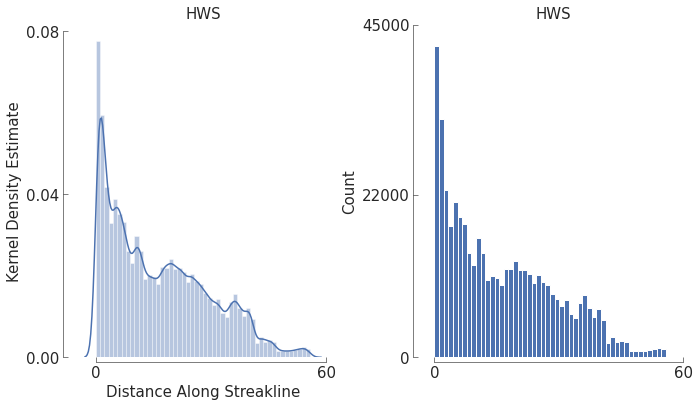

In [71]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
sns.distplot(df1.distance_from_source_a*df1.xsign, bins=50, kde=True, norm_hist=True, ax=ax1)
ax1.set_xlabel('Distance Along Streakline')
ax1.set_ylabel('Kernel Density Estimate')
ax1.grid(False)

ax1.set_title('HWS')
mpl_functions.adjust_spines(ax1,['left','bottom'],spine_locations={'bottom': 5}, 
                            smart_bounds=True, 
                            xticks=[0,60],
                            yticks=[0,0.04,0.08],
                            linewidth=0.5)

ax2.hist(df1.distance_from_source_a*df1.xsign, bins=50)
ax2.grid(False)
ax2.set_title('HWS')
ax2.set_ylabel('Count')
mpl_functions.adjust_spines(ax2,['left','bottom'],spine_locations={'bottom': 5}, 
                            smart_bounds=True, 
                            xticks=[0,60],
                            yticks=[0,22000,45000],
                            linewidth=0.5)
f.tight_layout(pad=2)
figurefirst.mpl_functions.set_fontsize(f, 15)
# f.savefig('../../Figure/hist_1.jpeg', dpi=300, bbox_inches = "tight")